In [162]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import natsort
import re
#We gebruiken de from ... import voor commando's die we veel gebruiken om repititie te verminderen 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from zipfile import ZipFile
import tensorflow as tf

UPLOAD EERST DE DATA ZIP in COLAB, ANDERS KAN HET VOLGENDE BLOK CODE DEZE NIET UITPAKKEN

In [163]:
standaarddirectory = os.getcwd()                  #standaarddirectory van google colab opslaan zodat we altijd terug kunnen keren naar deze
file_name = "delay_dataset.zip"                   
if not os.path.exists("stud_train"):              #Als de data nog niet uitgepakt is en deze folder dus nog niet bestaat, gaan we dit doen
  with ZipFile(file_name,'r') as zipper:
    zipper.extractall()
    print("extractie data klaar")

if not os.path.exists("stud_train_combined_ASDR"):    #Een folder waarin we de gecombineerde ASDR train signalen van 1024 samples zullen opslaan
  os.makedirs("stud_train_combined_ASDR")
if not os.path.exists("stud_train_combined_GAUSS"):   #Een folder waarin we de gecombineerde GAUSS train signalen van 1024 samples zullen opslaan
  os.makedirs("stud_train_combined_GAUSS")
if not os.path.exists("stud_train_combined_SBOX"):    #Een folder waarin we de gecombineerde SBOX train signalen van 1024 samples zullen opslaan
  os.makedirs("stud_train_combined_SBOX")

if not os.path.exists("stud_test_combined_ASDR"):    #Een folder waarin we de gecombineerde ASDR test signalen van 1024 samples zullen opslaan
  os.makedirs("stud_test_combined_ASDR")
if not os.path.exists("stud_test_combined_GAUSS"):   #Een folder waarin we de gecombineerde GAUSS test signalen van 1024 samples zullen opslaan
  os.makedirs("stud_test_combined_GAUSS")
if not os.path.exists("stud_test_combined_SBOX"):    #Een folder waarin we de gecombineerde SBOX test signalen van 1024 samples zullen opslaan
  os.makedirs("stud_test_combined_SBOX")

In [164]:
# variable declaration
train_set = 'stud_train'
test_set = 'stud_test'
delaypiekASDR = []    #array met actuele delays tussen de pieken (validatiecijfers voor training)
delaypiekGAUSS = []
delaypiekSBOX = []
delaypiekASDRtest = []    #array met actuele delays tussen de pieken (cijfers voor testing)
delaypiekGAUSStest = []
delaypiekSBOXtest = []

In [165]:
#Geeft een array met strings weer waarin de namen van de files in die map staan
def laadarraymetfilenamenuitmap(map):
    filenames = os.listdir(map)  # array met alle filenames van in folder
    filenames.sort()
    return filenames

In [166]:
#plot het signaal van een numpy array aan de hand van een megegeven signaalbestandsnaam
#Functie werd enkel gebruikt in het begin, niet meer relevant op het einde
def plotsignaal(signaal, evencheck, nummer, x = np.arange(0,512)): #signaal is naam bestand tussen aanhalingstekens
    if evencheck % 2 == 0:
        kleur = "red"         #paar van signalen respectievelijk rood en blauw weergeven zodat het verschil duidelijk is
    else:
        kleur = "blue"
    plot = plt.figure(nummer)
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    plt.plot(x,np.load(signaal), color=kleur)

In [167]:
#Geeft de waarde van de positie van die piek terug aan de hand van de bestandsnaam
def geefpositiepiek(signaal):
  truncatedsignaal = (signaal.split("P_",1)[1]) #alles voor de xxx wegdoen dus BV ASDR_P_ wegdoen
  piek = ''.join(x for x in truncatedsignaal[0:3] if x.isdigit()) 
  return piek

In [168]:
#voegt de array van twee signalen samen om 1 vector van 1024 samples te bekomen
def voegsamen(signaal1, signaal2):
  return np.concatenate([np.load(signaal1), np.load(signaal2)])

In [169]:
#wordt gebruikt om de lijst met de files te sorten op numerische orde ipv alfabetische orde om sortering van 0 1 10 11 ... 19 2 20 21 ... 29 3 30 31 etc te voorkomen maar 0 1 2 3 4 ... 99
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [170]:
def combinedata(folder, dir, delayarray, typesignaal = "", testoftrain = "", aantalgrafiekenplotten = 0):
  i = 0
  nummer = 1
  evencheck = 0
  x = np.arange(0, 1024)
  k = 0
  for data in folder:
    evencheck += 1
    if k != 0 and evencheck % 2 == 0:
      os.chdir(f"stud_{testoftrain}")
      masterfile = voegsamen(previous, data)
      os.chdir(standaarddirectory)

      os.chdir(dir)
      savename = f"{nummer}{typesignaal}.npy"
      np.save(savename,masterfile)
      os.chdir(standaarddirectory)
      nummer += 1
      delayarray.append(512-int(geefpositiepiek(previous))+int(geefpositiepiek(data)))

      #plotten voor eerste paar grafieken, mooie visualisatie als controle
      if evencheck < ((aantalgrafiekenplotten*2)+1):  #evencheck > aantal grafieken*2, max 41 vanwege memory limiet -> 20 grafieken, zet op 1 indien je geen grafieken wil zien
        plot= plt.figure(nummer)
        plt.plot(x,masterfile, color="red")

    k += 1
    previous = data

END OF FUNCTIONS

In [171]:
#main
#filenames inlezen
filenames = laadarraymetfilenamenuitmap(train_set)
filenamesASDR = filenames[0:200]
filenamesGAUSS = filenames[200:400]
filenamesSBOX = filenames[400:600]

filenamestest = laadarraymetfilenamenuitmap(test_set)
filenamesASDRtest = filenamestest[0:200]
filenamesGAUSStest = filenamestest[200:400]
filenamesSBOXtest = filenamestest[400:600]

#sorteren
filenamesASDR.sort(key=natural_keys)
filenamesGAUSS.sort(key=natural_keys)
filenamesSBOX.sort(key=natural_keys)
filenamesASDRtest.sort(key=natural_keys)
filenamesGAUSStest.sort(key=natural_keys)
filenamesSBOXtest.sort(key=natural_keys)

In [172]:
os.chdir(standaarddirectory)
combinedata(filenamesASDR, "stud_train_combined_ASDR", delaypiekASDR, "ASDR", "train")
combinedata(filenamesGAUSS, "stud_train_combined_GAUSS", delaypiekGAUSS, "GAUSS", "train")
combinedata(filenamesSBOX, "stud_train_combined_SBOX", delaypiekSBOX, "SBOX", "train")

combinedata(filenamesASDRtest, "stud_test_combined_ASDR", delaypiekASDRtest, "ASDR", "test")
combinedata(filenamesGAUSStest, "stud_test_combined_GAUSS", delaypiekGAUSStest, "GAUSS", "test")
combinedata(filenamesSBOXtest, "stud_test_combined_SBOX", delaypiekSBOXtest, "SBOX", "test")

In [173]:
#TENSOR Object maken voor x waarden NN training
os.chdir(standaarddirectory)
os.chdir("stud_train_combined_ASDR")

samplesASDR = [np.load(f"{x}ASDR.npy") for x in range(1, 101)]
samplesASDR = tf.convert_to_tensor(samplesASDR)

os.chdir(standaarddirectory)

In [174]:
#TENSOR Object maken voor x waarden NN testing
os.chdir(standaarddirectory)
os.chdir("stud_test_combined_ASDR")

samplesASDRtest = [np.load(f"{x}ASDR.npy") for x in range(1, 101)]
samplesASDRtest = tf.convert_to_tensor(samplesASDRtest)

os.chdir(standaarddirectory)

In [175]:
#TENSOR object maken voor y waarden NN training
delayASDR = pd.DataFrame(data = delaypiekASDR)
delayASDR = tf.convert_to_tensor(delayASDR)

In [176]:
#Model aanmaken
modelASDR = tf.keras.Sequential()
modelASDR.add(layers.Dense(512, activation='relu', input_shape=(1024,)))
modelASDR.add(layers.Dense(256, activation='relu'))
modelASDR.add(layers.Dense(64, activation='relu'))
modelASDR.add(layers.Dense(8, activation='relu'))
modelASDR.add(layers.Dense(1))

In [177]:
modelASDR.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 512)               524800    
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                                 
 dense_32 (Dense)            (None, 64)                16448     
                                                                 
 dense_33 (Dense)            (None, 8)                 520       
                                                                 
 dense_34 (Dense)            (None, 1)                 9         
                                                                 
Total params: 673,105
Trainable params: 673,105
Non-trainable params: 0
_________________________________________________________________


In [178]:
#Optimizer, loss function en metrics toevoegen aan model en compileren
modelASDR.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [179]:
#Model Trainen
history = modelASDR.fit(samplesASDR,
                        delayASDR,
                        epochs=20)

Epoch 1/20
4/4 [==============================] - 1s 9ms/step - loss: 573.5174 - mae: 573.5174
Epoch 2/20
4/4 [==============================] - 0s 12ms/step - loss: 557.1340 - mae: 557.1340
Epoch 3/20
4/4 [==============================] - 0s 9ms/step - loss: 514.1002 - mae: 514.1002
Epoch 4/20
4/4 [==============================] - 0s 9ms/step - loss: 420.6487 - mae: 420.6487
Epoch 5/20
4/4 [==============================] - 0s 11ms/step - loss: 241.7795 - mae: 241.7795
Epoch 6/20
4/4 [==============================] - 0s 9ms/step - loss: 100.5261 - mae: 100.5261
Epoch 7/20
4/4 [==============================] - 0s 8ms/step - loss: 154.0433 - mae: 154.0433
Epoch 8/20
4/4 [==============================] - 0s 11ms/step - loss: 71.3509 - mae: 71.3509
Epoch 9/20
4/4 [==============================] - 0s 12ms/step - loss: 103.4953 - mae: 103.4953
Epoch 10/20
4/4 [==============================] - 0s 8ms/step - loss: 78.3817 - mae: 78.3817
Epoch 11/20
4/4 [==============================] 

In [180]:
predictionsASDR = modelASDR.predict(samplesASDRtest)

4/4 [==============================] - 0s 5ms/step


[114, 31, 79, 24, 12, 76, 138, 71, 24, 81, 82, 86, 14, 144, 17, 207, 138, 14, 44, 69, 20, 218, 53, 133, 5, 34, 62, 168, 151, 52, 12, 32, 56, 52, 48, 20, 47, 71, 46, 91, 12, 14, 21, 31, 74, 34, 15, 42, 33, 50, 61, 57, 140, 26, 140, 45, 64, 42, 94, 24, 23, 127, 79, 58, 7, 121, 37, 128, 25, 46, 134, 89, 47, 191, 90, 56, 127, 26, 88, 3, 159, 106, 2, 41, 72, 58, 137, 57, 76, 20, 11, 9, 83, 104, 90, 147, 44, 176, 161, 44]
[482.5005187988281, 636.6365356445312, 472.7707214355469, 623.0552368164062, 571.3115844726562, 484.3056945800781, 701.2522583007812, 613.8311157226562, 536.4218139648438, 461.1441955566406, 529.4033813476562, 653.6182250976562, 556.6815795898438, 430.1792297363281, 574.4596557617188, 749.2724609375, 468.8686828613281, 532.8651123046875, 543.4305419921875, 644.5924072265625, 569.173095703125, 380.7334289550781, 660.6589965820312, 464.5780944824219, 552.5106811523438, 513.1600952148438, 550.308837890625, 732.5596313476562, 699.8977661132812, 600.6491088867188, 557.6405639648

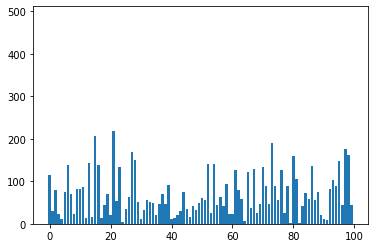

In [181]:
predictionslistASDR = predictionsASDR.tolist()
predictionslistASDRflat = [item for sublist in predictionslistASDR for item in sublist]

error_list_ASDR = []   #absolute waarde van de fout van predictie 
for error1, error2 in zip(predictionslistASDRflat, delaypiekASDRtest):
  error_list_ASDR.append(round(abs(error1 - error2)))

print(error_list_ASDR)
print(predictionslistASDRflat)
print(delaypiekASDRtest)
#visualiseren error
bar = plt.figure(1)
plt.bar(np.arange(0, 100), error_list_ASDR)
plt.ylim(0, 512)
plt.show()


MODEL VOOR GAUSS